# pyfabric example 4: CDJ nano-CT data
Fabric tensor of CDJ interzone

Created on:  01.12.2024 <br />
Last update: 04.05.2024 <br />

- By: [Gianluca Iori](https://github.com/gianthk), 2024
- Data source: QCT and HR-pQCT datasets were collected within the ANR-DFG TaCoSound project.
- Code license: MIT
- Narrative license: CC-BY-NC-SA

## Dataset info
- Filename: AA-39.raw
- Width: 1,085 px (108,283 mm)
- Height: 1,151 px (114,869.80 mm)
- Depth: 2,160 px (215,568 mm)
- Time steps: 1
- Voxels: 2,697,483,600
- PixelSize: 0.117 (um) (?)
- Size: 5145 Mb  Data type: USHORT
- Volume: 2,681,331,046,623,331 mm³

---
## Aims
1. Load and inspect nano-CT '.RAW' dataset
2. crop
3. compute mesh for pyfabric analysis
4. pyfabric worm
5. save as VTK mesh

---
## Configuration and imports

In [1]:
import os
import sys

In [2]:
# giiori@terminus
sys.path.append('/usr/terminus/data-xrm-01/stamplab/users/giiori/code/pyfabric') 
# sys.path.append('/home/gianthk/PycharmProjects/BEATS/recon_utils')

In [ ]:
# beatsbs@BL-BEATS-WS01
# sys.path.append('/home/beatsbs/PycharmProjects/user/pyfabric')
# sys.path.append('/home/beatsbs/PycharmProjects/recon_utils')

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.filters import threshold_multiotsu
from skimage import morphology
from skimage.measure import label, regionprops, regionprops_table
import heapq
from tqdm import tqdm
import pandas as pd
import SimpleITK as sitk
from scipy.ndimage import zoom

# from imaging_utils import periosteummask
from resources.myshow import myshow, myshow3d
from recon_utils import plot_midplanes, plot_projections
import pyfabric
from resources.pyfabric_image_utils import dist_table, markers_coors, resample_img, vectors2rotation3Dmatrix, align_with_XYplane, align_with_vectors, resample, affine_trans

In [5]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

## Functions definition

In [6]:
def plot_midplanes_sitk(img):
    plot_midplanes(sitk.GetArrayFromImage(img))

def plot_projections_sitk(img):
    plot_projections(sitk.GetArrayFromImage(img))

## Computational workflow
### Settings

In [7]:
# giiori@terminus
work_dir = '/usr/terminus/data-xrm-01/stamplab/users/giiori/2024/2024-12-InterDent_CDJ_nanoCT'
data_dir = '/usr/terminus/data-xrm-01/stamplab/users/giiori/2024/2024-12-InterDent_CDJ_nanoCT/Data'
output_dir = work_dir 

In [8]:
# Dataset info
filenameraw = 'AA-39.raw'
input_file_HR = os.path.join(data_dir, filenameraw)
# vs = np.ones([3]) * 117*1E-9 # voxelsize (m)
vs = np.ones([3]) * 117 # voxelsize (nm)

### Read and inspect RAW image data

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 139.42it/s]


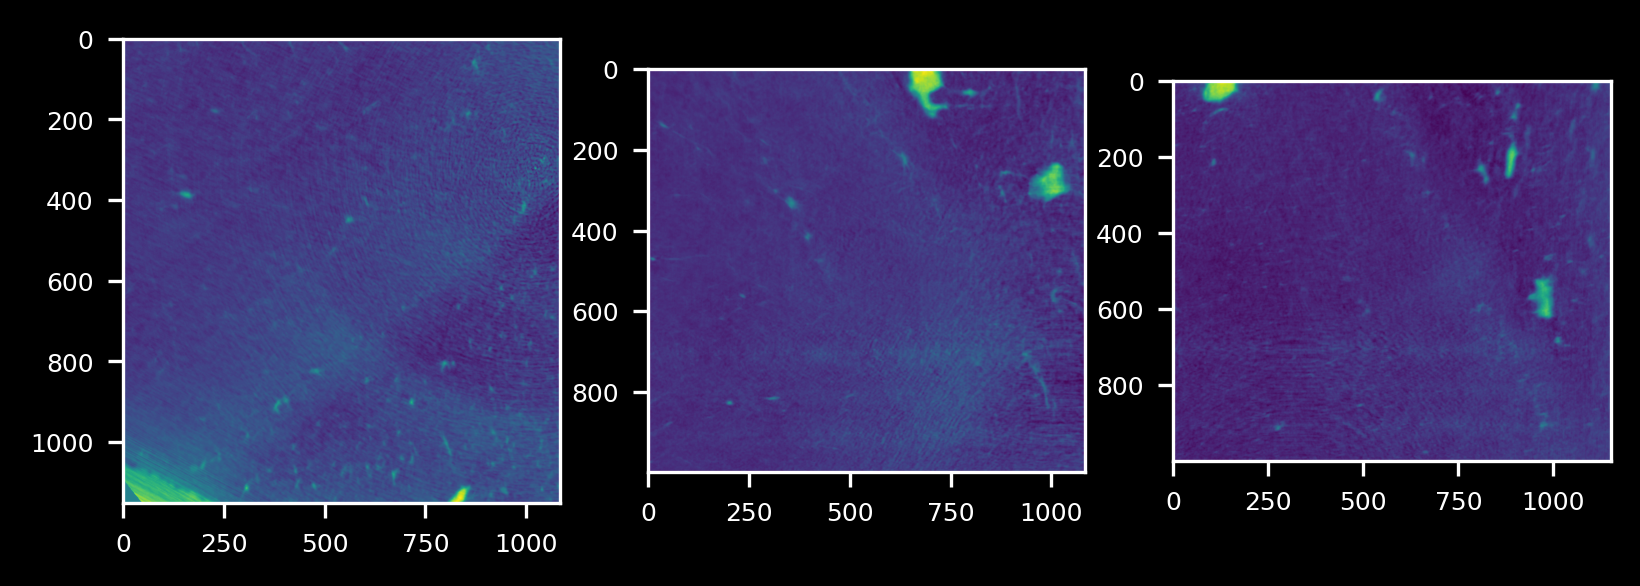

In [9]:
# data_3D_size = np.array((2160,2171,2171),dtype='uint16') #Or read that from your info File
data_3D_size = np.array((2160,1151,1085),dtype=int) #Or read that from your info File
n_slices=1000

data_3D = np.zeros((n_slices, data_3D_size[1], data_3D_size[2]))
f = open(input_file_HR,'rb') #only opens the file for reading
for i in tqdm(range(0,n_slices)):
    slice_array = np.fromfile(f,dtype='uint16',count=data_3D_size[1]*data_3D_size[2])
    data_3D[i,:,:] = slice_array.reshape(data_3D_size[1],data_3D_size[2])

plot_midplanes(data_3D)

#### Write to disk as MetaImage

In [ ]:
# itk.imwrite(data_3D, output_file_HR)

### Resample dataset
- resample image for faster test compartment masks calculation

In [12]:
vs_res = 3 * vs

In [ ]:
# With sitk
# data_3D_res = resample_img(data_3D, out_spacing=vs_res)

In [ ]:
# with scikit
data_3D_res = zoom(data_3D, vs/vs_res)
plot_midplanes(data_3D_res)

#### Pass it to ITK image

In [17]:
data_3D_res = sitk.GetImageFromArray(data_3D_res)
data_3D_res.SetOrigin((0, 0, 0))
data_3D_res.SetSpacing(vs_res)

### Median filter
We create a filtered copy of the QCT dataset for segmentation of bone compartments

In [18]:
filter = sitk.MedianImageFilter()
filter.SetRadius(1)
data_3D_res_med = filter.Execute(data_3D_res)

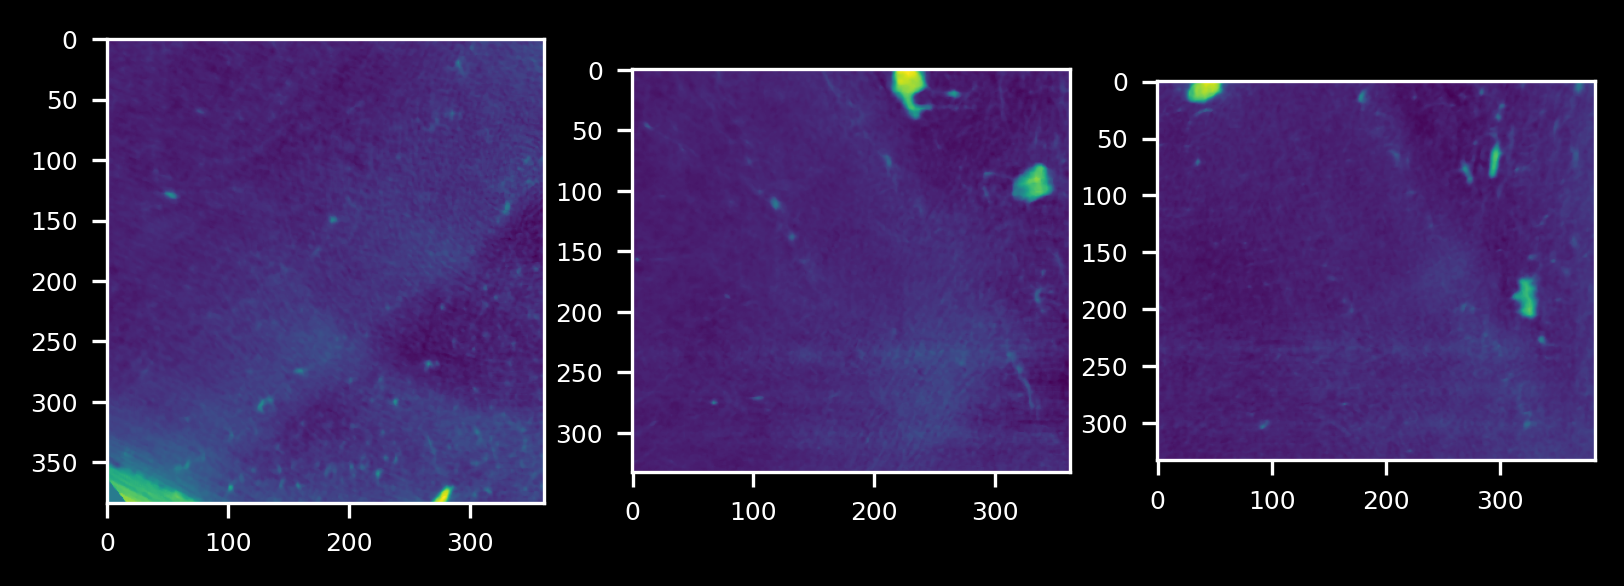

In [19]:
plot_midplanes_sitk(data_3D_res_med)

## Segment tissue

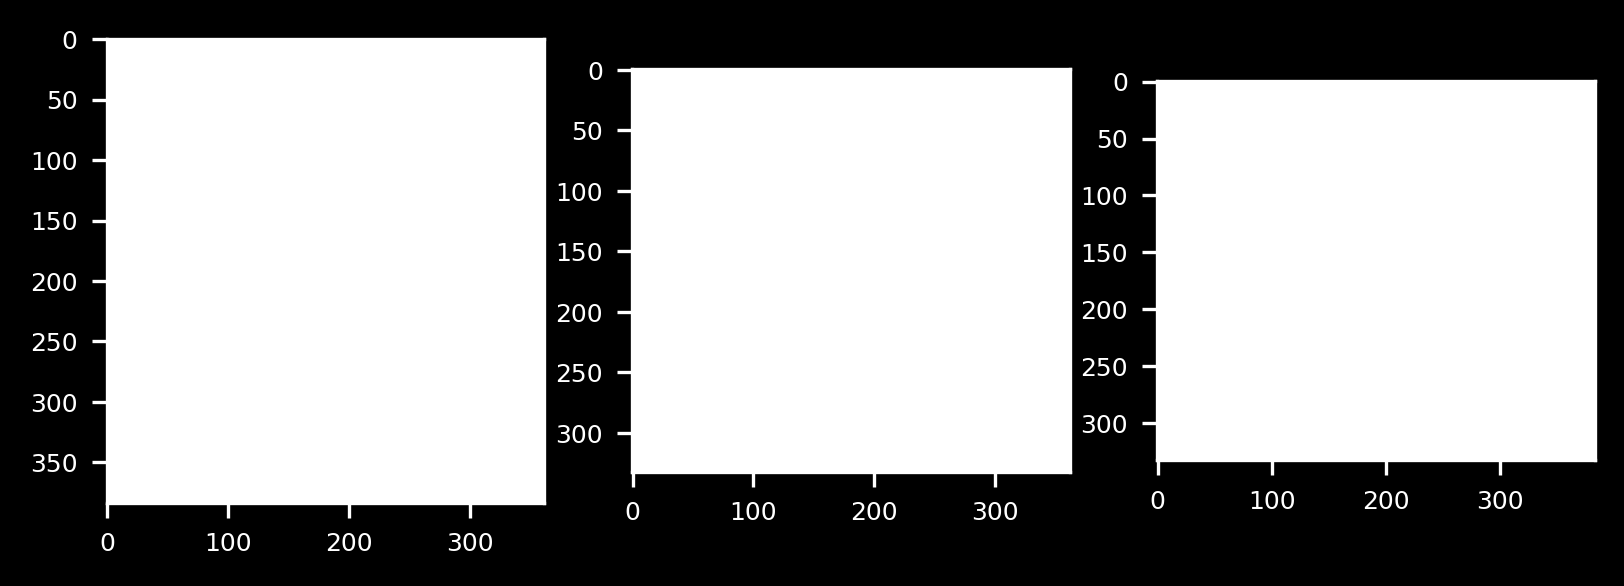

In [ ]:
data_3D_res_med_label = sitk.OtsuThreshold(data_3D_res_med)
# data_3D_res_med_overlay = sitk.LabelOverlay(image=data_3D_res, labelImage=data_3D_res_med_label, opacity=0.5, backgroundValue=0)
# plot_midplanes_sitk(data_3D_res_med_overlay)

## Mesh of Cement and Dentin tissue
Create tetrahedra mesh using [CGAL](https://www.cgal.org/) through [pygalmesh](https://github.com/nschloe/pygalmesh)

In [24]:
import pygalmesh

ModuleNotFoundError: No module named 'pygalmesh'

In [35]:
# mesh_trab = pygalmesh.generate_from_array(np.transpose(data_3D_BW_trab, [2, 1, 0]).astype('uint8'),
#                                           tuple(vs),
#                                           max_facet_distance=size_f*min(vs),
#                                           max_cell_circumradius=3*size_f*min(vs)
#                                          )

In [ ]:
# min_facet_angle=20,  lloyd=True,
size_f = 4 # size factor
mesh_trab = pygalmesh.generate_from_array(np.transpose(sitk.GetArrayFromImage(data_3D_BW_trab), [2, 1, 0]),
                                          data_3D_BW_trab.GetSpacing(),
                                          max_facet_distance=size_f*min(data_3D_BW_trab.GetSpacing()),
                                          max_cell_circumradius=3*size_f*min(data_3D_BW_trab.GetSpacing())
                                         )

Remove triangles

In [210]:
mesh_trab.remove_lower_dimensional_cells()

{'triangle'}

Write VTK mesh with [meshio](https://github.com/nschloe/meshio)

In [16]:
output_QCT_R_HR_mesh_trab = os.path.join(data_dir, 'QCT/QCTFEMUR_1955L/masks/QCTFEMUR_1955L_R_HR_trab_mesh_max_facet3mm_max_cell_circ9mm_noOrigin.vtk')
print(output_QCT_R_HR_mesh_trab)

/run/media/beatsbs/My Passport/Data/TacoSound/QCT/QCTFEMUR_1955L/masks/QCTFEMUR_1955L_R_HR_trab_mesh_max_facet3mm_max_cell_circ9mm.vtk


In [212]:
mesh_trab.write(output_QCT_R_HR_mesh_trab)

Reload the mesh (if you have already generated it and want to start the notebook from this point)

In [9]:
import meshio
mesh_trab = meshio.read(output_QCT_R_HR_mesh_trab)

### Get Barycenter of each cell of the trabecular core (QCT data)

In [217]:
# cells barycenter coordinates
cells_bary = np.sum(mesh_trab.points[mesh_trab.cells[0][1][:]], 1)/mesh_trab.points[mesh_trab.cells[0][1][:]].shape[1] # x, y, z

Save array of cells barycenters coordinates

In [328]:
# output_trab_cells_bary = os.path.join(data_dir, 'QCT/QCTFEMUR_1955L/masks/QCTFEMUR_1955L_R_HR_trab_mesh_barycenters_noOrigin.npy')
output_trab_cells_bary = os.path.join(data_dir, 'QCT/QCTFEMUR_1955L/masks/QCTFEMUR_1955L_R_HR_trab_mesh_barycenters.npy')

print(output_trab_cells_bary)

/run/media/beatsbs/My Passport/Data/TacoSound/QCT/QCTFEMUR_1955L/masks/QCTFEMUR_1955L_R_HR_trab_mesh_barycenters.npy


In [219]:
np.save(output_trab_cells_bary, cells_bary)

Reload it

In [329]:
cells_bary = np.load(output_trab_cells_bary)
print(cells_bary.shape)

(885, 3)


## Crop trabecular bone portions
--- testing ---

In [ ]:
extract = sitk.ExtractImageFilter()
extract.SetSize([1, 4608, 5921])
extract.SetIndex([2304, 0, 0])
extracted_image = extract.Execute(data_3D)

plot_midplanes_sitk(extracted_image)

In [ ]:
extract = sitk.ExtractImageFilter()
extract.SetSize([1, 512, 659])
extract.SetIndex([256, 0, 0])
extracted_image = extract.Execute(data_3D_QCT_trans)

plot_midplanes_sitk(extracted_image)

---
# scratch: